In [15]:
# Install FLOPs library (only needed once in Colab/local)
%pip install ptflops

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import copy, math
import matplotlib.pyplot as plt
import numpy as np

from ptflops import get_model_complexity_info

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Using device: cpu


Dataset Preparation (CIFAR-10 split into 2 clients)

In [16]:
# Base transforms
transform_base = transforms.Compose([transforms.ToTensor()])

# SSL augmentations (SimCLR style)
ssl_aug = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    transforms.ToTensor()
])

# Load CIFAR-10
train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_base)
test_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_base)

# Split train dataset into 2 clients
n = len(train_ds)
c1 = n // 2
c2 = n - c1
client1_ds, client2_ds = random_split(train_ds, [c1, c2])

BATCH = 128
client1_loader = DataLoader(client1_ds, batch_size=BATCH, shuffle=True)
client2_loader = DataLoader(client2_ds, batch_size=BATCH, shuffle=True)
test_loader    = DataLoader(test_ds, batch_size=256, shuffle=False)

Model Definition (Tiny CNN + Projection Head)

In [17]:
class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(3, 32, 3, padding=1),   # Layer 1
            nn.Conv2d(32, 64, 3, padding=1),  # Layer 2
            nn.Conv2d(64, 128, 3, padding=1)  # Layer 3
        ])
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        # Different projection heads for different depths
        self.proj_heads = nn.ModuleDict({
            '1': nn.Sequential(
                nn.Flatten(),
                nn.Linear(32, 128),   # depth 1: 32 features -> 128
                nn.ReLU(),
                nn.Linear(128, 128)
            ),
            '2': nn.Sequential(
                nn.Flatten(),
                nn.Linear(64, 128),   # depth 2: 64 features -> 128
                nn.ReLU(),
                nn.Linear(128, 128)
            ),
            '3': nn.Sequential(
                nn.Flatten(),
                nn.Linear(128, 256),  # depth 3: 128 features -> 256 -> 128
                nn.ReLU(),
                nn.Linear(256, 128)
            )
        })
        
    def forward(self, x, depth):
        for i in range(depth):
            x = F.relu(self.layers[i](x))
        x = self.pool(x)
        return self.proj_heads[str(depth)](x)

Utilities (Freezing, SSL loss, Memory/FLOPs helpers)

In [18]:
def freeze_old_layers(model, active_layer_idx):
    for i, layer in enumerate(model.layers):
        for p in layer.parameters():
            p.requires_grad = (i == active_layer_idx)
    # Always allow gradients for all projection heads
    for proj_head in model.proj_heads.values():
        for p in proj_head.parameters():
            p.requires_grad = True

def simclr_nt_xent(z1, z2, tau=0.5):
    z1, z2 = F.normalize(z1, dim=1), F.normalize(z2, dim=1)
    logits = torch.mm(z1, z2.t()) / tau
    labels = torch.arange(z1.size(0), device=z1.device)
    return F.cross_entropy(logits, labels)

def ssl_batch_augment(batch_images):
    return (
        torch.stack([ssl_aug(transforms.ToPILImage()(img)) for img in batch_images]),
        torch.stack([ssl_aug(transforms.ToPILImage()(img)) for img in batch_images])
    )

# FLOPs helper
class DepthWrapper(nn.Module):
    def __init__(self, base_model, depth):
        super().__init__()
        self.base = base_model
        self.depth = depth
    def forward(self, x):
        return self.base(x, depth=self.depth)

def compute_forward_flops(model, depth, input_res=(3,32,32)):
    wrapper = DepthWrapper(model, depth).to(device)
    macs, _ = get_model_complexity_info(wrapper, input_res, as_strings=False, print_per_layer_stat=False)
    return macs / 1e9  # GFLOPs

def get_param_size_bytes(layer):
    return sum(p.numel() * p.element_size() for p in layer.parameters())

Client Training Functions (LW-FedSSL & FedSSL)

In [19]:
BACKWARD_RATIO = 2.0  # approx cost of backward pass vs forward

def client_train_lw(model, dataloader, stage_depth, local_epochs=1):
    active_idx = stage_depth - 1
    model_local = copy.deepcopy(model).to(device)
    freeze_old_layers(model_local, active_idx)
    opt = optim.Adam(filter(lambda p: p.requires_grad, model_local.parameters()), lr=1e-3)

    for _ in range(local_epochs):
        for xb, _ in dataloader:
            print(f"Shape of input batch (xb): {xb.shape}") # Added print
            x1, x2 = ssl_batch_augment(xb)
            print(f"Shape of augmented batch 1 (x1): {x1.shape}") # Added print
            print(f"Shape of augmented batch 2 (x2): {x2.shape}") # Added print
            x1, x2 = x1.to(device), x2.to(device)
            z1, z2 = model_local(x1, depth=stage_depth), model_local(x2, depth=stage_depth)
            loss = simclr_nt_xent(z1, z2)
            opt.zero_grad(); loss.backward(); opt.step()
            break  # just one batch per epoch (demo)

    # Compute FLOPs
    fwd_all = compute_forward_flops(model_local, depth=stage_depth)
    fwd_active = compute_forward_flops(model_local, depth=1)  # approx
    flops = fwd_all + BACKWARD_RATIO * fwd_active

    return {k: v.cpu() for k,v in model_local.layers[active_idx].state_dict().items()}, flops

def client_train_fedssl(model, dataloader, local_epochs=1):
    model_local = copy.deepcopy(model).to(device)
    for p in model_local.parameters(): p.requires_grad = True
    opt = optim.Adam(model_local.parameters(), lr=1e-3)

    for _ in range(local_epochs):
        for xb, _ in dataloader:
            x1, x2 = ssl_batch_augment(xb)
            x1, x2 = x1.to(device), x2.to(device)
            z1, z2 = model_local(x1, depth=3), model_local(x2, depth=3)
            loss = simclr_nt_xent(z1, z2)
            opt.zero_grad(); loss.backward(); opt.step()
            break

    fwd_all = compute_forward_flops(model_local, depth=3)
    flops = fwd_all * (1 + BACKWARD_RATIO)
    return {k: v.cpu() for k,v in model_local.state_dict().items()}, flops

Server Aggregation Helpers

In [20]:
def aggregate_layer_dicts(dicts):
    agg = {}
    for k in dicts[0].keys():
        agg[k] = torch.mean(torch.stack([d[k].float() for d in dicts]), dim=0)
    return agg

def aggregate_full_models(dicts):
    agg = {}
    for k in dicts[0].keys():
        agg[k] = torch.mean(torch.stack([d[k].float() for d in dicts]), dim=0)
    return agg

Run LW-FedSSL & FedSSL Training

In [21]:
def run_lw_fedssl():
    model = TinyCNN().to(device)
    comms, flops = [], []
    for stage in range(1,4):  # 3 layers
        u1, f1 = client_train_lw(model, client1_loader, stage)
        u2, f2 = client_train_lw(model, client2_loader, stage)
        agg = aggregate_layer_dicts([u1, u2])
        model.layers[stage-1].load_state_dict(agg)
        size_MB = get_param_size_bytes(model.layers[stage-1]) * 2 / (1024**2)
        comms.append(size_MB); flops.append((f1+f2)/2)
    return model, sum(comms), np.mean(flops)

def run_fedssl():
    model = TinyCNN().to(device)
    comms, flops = [], []
    for _ in range(3):  # 3 rounds
        u1, f1 = client_train_fedssl(model, client1_loader)
        u2, f2 = client_train_fedssl(model, client2_loader)
        agg = aggregate_full_models([u1, u2])
        model.load_state_dict(agg)
        size_MB = sum(p.numel()*p.element_size() for p in model.parameters()) * 2 / (1024**2)
        comms.append(size_MB); flops.append((f1+f2)/2)
    return model, sum(comms), np.mean(flops)

print("Running LW-FedSSL...")
lw_model, lw_comm, lw_flops = run_lw_fedssl()

print("Running FedSSL...")
fed_model, fed_comm, fed_flops = run_fedssl()

Running LW-FedSSL...
Shape of input batch (xb): torch.Size([128, 3, 32, 32])
Shape of augmented batch 1 (x1): torch.Size([128, 3, 32, 32])
Shape of augmented batch 2 (x2): torch.Size([128, 3, 32, 32])
Shape of input batch (xb): torch.Size([128, 3, 32, 32])
Shape of augmented batch 1 (x1): torch.Size([128, 3, 32, 32])
Shape of augmented batch 2 (x2): torch.Size([128, 3, 32, 32])
Shape of input batch (xb): torch.Size([128, 3, 32, 32])
Shape of augmented batch 1 (x1): torch.Size([128, 3, 32, 32])
Shape of augmented batch 2 (x2): torch.Size([128, 3, 32, 32])
Shape of input batch (xb): torch.Size([128, 3, 32, 32])
Shape of augmented batch 1 (x1): torch.Size([128, 3, 32, 32])
Shape of augmented batch 2 (x2): torch.Size([128, 3, 32, 32])
Shape of input batch (xb): torch.Size([128, 3, 32, 32])
Shape of augmented batch 1 (x1): torch.Size([128, 3, 32, 32])
Shape of augmented batch 2 (x2): torch.Size([128, 3, 32, 32])
Shape of input batch (xb): torch.Size([128, 3, 32, 32])
Shape of augmented batc

Linear Probe Evaluation

In [22]:
class LinearProbe(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.enc = encoder
        self.fc = nn.Linear(128, 10)
    def forward(self, x):
        with torch.no_grad():
            z = self.enc(x, depth=3)
        return self.fc(z)

def linear_probe_acc(encoder, train_loader, test_loader, epochs=3):
    probe = LinearProbe(encoder).to(device)
    opt = optim.Adam(probe.fc.parameters(), lr=1e-3)
    for _ in range(epochs):
        for xb,yb in train_loader:
            xb,yb = xb.to(device), yb.to(device)
            logits = probe(xb)
            loss = F.cross_entropy(logits, yb)
            opt.zero_grad(); loss.backward(); opt.step()
    # eval
    correct,total=0,0
    with torch.no_grad():
        for xb,yb in test_loader:
            xb,yb = xb.to(device), yb.to(device)
            pred = probe(xb).argmax(1)
            correct += (pred==yb).sum().item()
            total += yb.size(0)
    return 100*correct/total

lw_acc = linear_probe_acc(lw_model, DataLoader(client1_ds,batch_size=128), test_loader)
fed_acc = linear_probe_acc(fed_model, DataLoader(client1_ds,batch_size=128), test_loader)

print(f"LW-FedSSL Acc: {lw_acc:.2f}%")
print(f"FedSSL Acc:    {fed_acc:.2f}%")

LW-FedSSL Acc: 11.56%
FedSSL Acc:    19.35%


=== SUMMARY ===
LW-FedSSL: Comm=0.71 MB, FLOPs=0.041 G/sample, Acc=11.56%
FedSSL:    Comm=4.69 MB, FLOPs=0.288 G/sample, Acc=19.35%


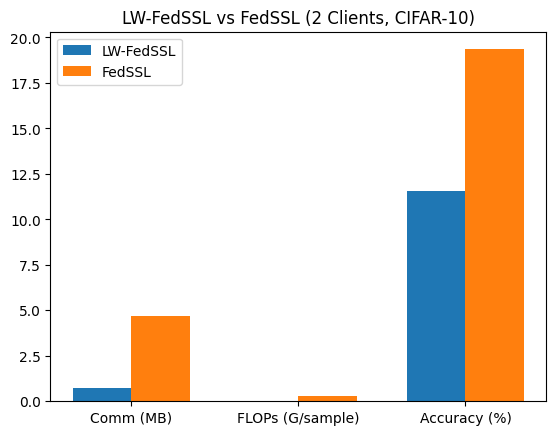

In [23]:
print("=== SUMMARY ===")
print(f"LW-FedSSL: Comm={lw_comm:.2f} MB, FLOPs={lw_flops:.3f} G/sample, Acc={lw_acc:.2f}%")
print(f"FedSSL:    Comm={fed_comm:.2f} MB, FLOPs={fed_flops:.3f} G/sample, Acc={fed_acc:.2f}%")

labels = ["Comm (MB)", "FLOPs (G/sample)", "Accuracy (%)"]
lw_vals = [lw_comm, lw_flops, lw_acc]
fed_vals= [fed_comm, fed_flops, fed_acc]

x = np.arange(len(labels))
w = 0.35
plt.bar(x-w/2, lw_vals, w, label="LW-FedSSL")
plt.bar(x+w/2, fed_vals, w, label="FedSSL")
plt.xticks(x, labels)
plt.legend()
plt.title("LW-FedSSL vs FedSSL (2 Clients, CIFAR-10)")
plt.show()

## Issues Identified and Fixes Needed

### Major Issues:
1. **Only training on 1 batch per epoch** - Remove the `break` statement
2. **Too few epochs** - Increase local_epochs to 5-10
3. **Too few rounds** - Increase rounds to 10-20
4. **Linear probe under-trained** - Increase probe training epochs to 10-20

### Quick Fixes to Try:

In [25]:
# IMPROVED TRAINING FUNCTIONS - Fixed Version

def client_train_lw_improved(model, dataloader, stage_depth, local_epochs=5):
    """Improved LW-FedSSL training - trains on full dataset"""
    active_idx = stage_depth - 1
    model_local = copy.deepcopy(model).to(device)
    freeze_old_layers(model_local, active_idx)
    opt = optim.Adam(filter(lambda p: p.requires_grad, model_local.parameters()), lr=1e-3)

    for epoch in range(local_epochs):
        total_loss = 0
        num_batches = 0
        for xb, _ in dataloader:
            x1, x2 = ssl_batch_augment(xb)
            x1, x2 = x1.to(device), x2.to(device)
            z1, z2 = model_local(x1, depth=stage_depth), model_local(x2, depth=stage_depth)
            loss = simclr_nt_xent(z1, z2)
            opt.zero_grad(); loss.backward(); opt.step()
            total_loss += loss.item()
            num_batches += 1
            # Remove the break statement to train on full dataset!
        
        if (epoch + 1) % 2 == 0:
            print(f"Stage {stage_depth}, Epoch {epoch+1}, Avg Loss: {total_loss/num_batches:.4f}")

    # Compute FLOPs
    fwd_all = compute_forward_flops(model_local, depth=stage_depth)
    fwd_active = compute_forward_flops(model_local, depth=1)
    flops = fwd_all + BACKWARD_RATIO * fwd_active

    return {k: v.cpu() for k,v in model_local.layers[active_idx].state_dict().items()}, flops

def client_train_fedssl_improved(model, dataloader, local_epochs=5):
    """Improved FedSSL training - trains on full dataset"""
    model_local = copy.deepcopy(model).to(device)
    for p in model_local.parameters(): p.requires_grad = True
    opt = optim.Adam(model_local.parameters(), lr=1e-3)

    for epoch in range(local_epochs):
        total_loss = 0
        num_batches = 0
        for xb, _ in dataloader:
            x1, x2 = ssl_batch_augment(xb)
            x1, x2 = x1.to(device), x2.to(device)
            z1, z2 = model_local(x1, depth=3), model_local(x2, depth=3)
            loss = simclr_nt_xent(z1, z2)
            opt.zero_grad(); loss.backward(); opt.step()
            total_loss += loss.item()
            num_batches += 1
            # Remove the break statement!
            
        if (epoch + 1) % 2 == 0:
            print(f"FedSSL Epoch {epoch+1}, Avg Loss: {total_loss/num_batches:.4f}")

    fwd_all = compute_forward_flops(model_local, depth=3)
    flops = fwd_all * (1 + BACKWARD_RATIO)
    return {k: v.cpu() for k,v in model_local.state_dict().items()}, flops

In [26]:
# IMPROVED MAIN TRAINING LOOPS

def run_lw_fedssl_improved():
    """Improved LW-FedSSL with more rounds and proper training"""
    model = TinyCNN().to(device)
    comms, flops = [], []
    
    # Increase number of rounds from 3 to 10
    num_rounds = 10
    print(f"Running LW-FedSSL for {num_rounds} rounds...")
    
    for stage in range(1, 4):  # 3 layers
        print(f"\n=== Training Stage {stage} ===")
        stage_comms, stage_flops = [], []
        
        for round_num in range(num_rounds):
            print(f"Round {round_num + 1}/{num_rounds}")
            u1, f1 = client_train_lw_improved(model, client1_loader, stage, local_epochs=3)
            u2, f2 = client_train_lw_improved(model, client2_loader, stage, local_epochs=3)
            agg = aggregate_layer_dicts([u1, u2])
            model.layers[stage-1].load_state_dict(agg)
            
            size_MB = get_param_size_bytes(model.layers[stage-1]) * 2 / (1024**2)
            stage_comms.append(size_MB)
            stage_flops.append((f1+f2)/2)
        
        comms.extend(stage_comms)
        flops.extend(stage_flops)
    
    return model, sum(comms), np.mean(flops)

def run_fedssl_improved():
    """Improved FedSSL with more rounds and proper training"""
    model = TinyCNN().to(device)
    comms, flops = [], []
    
    # Increase number of rounds from 3 to 10
    num_rounds = 10
    print(f"Running FedSSL for {num_rounds} rounds...")
    
    for round_num in range(num_rounds):
        print(f"Round {round_num + 1}/{num_rounds}")
        u1, f1 = client_train_fedssl_improved(model, client1_loader, local_epochs=3)
        u2, f2 = client_train_fedssl_improved(model, client2_loader, local_epochs=3)
        agg = aggregate_full_models([u1, u2])
        model.load_state_dict(agg)
        
        size_MB = sum(p.numel()*p.element_size() for p in model.parameters()) * 2 / (1024**2)
        comms.append(size_MB)
        flops.append((f1+f2)/2)
    
    return model, sum(comms), np.mean(flops)

In [27]:
# IMPROVED LINEAR PROBE EVALUATION

def linear_probe_acc_improved(encoder, train_loader, test_loader, epochs=15):
    """Improved linear probe with more training epochs"""
    probe = LinearProbe(encoder).to(device)
    opt = optim.Adam(probe.fc.parameters(), lr=1e-3)
    
    print(f"Training linear probe for {epochs} epochs...")
    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = probe(xb)
            loss = F.cross_entropy(logits, yb)
            opt.zero_grad(); loss.backward(); opt.step()
            total_loss += loss.item()
            num_batches += 1
        
        if (epoch + 1) % 5 == 0:
            print(f"Probe Epoch {epoch+1}, Avg Loss: {total_loss/num_batches:.4f}")
    
    # Evaluation
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = probe(xb).argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    return 100 * correct / total

In [28]:
# QUICK TEST WITH FEWER ROUNDS (for demonstration)
print("=" * 60)
print("RUNNING QUICK TEST OF IMPROVED IMPLEMENTATIONS")
print("=" * 60)

def run_lw_fedssl_quick_test():
    """Quick test version with fewer rounds"""
    model = TinyCNN().to(device)
    comms, flops = [], []
    
    for stage in range(1, 4):  # 3 layers
        print(f"\n=== Training Stage {stage} ===")
        # Just 2 rounds for quick test
        for round_num in range(2):
            print(f"Round {round_num + 1}/2")
            u1, f1 = client_train_lw_improved(model, client1_loader, stage, local_epochs=2)
            u2, f2 = client_train_lw_improved(model, client2_loader, stage, local_epochs=2)
            agg = aggregate_layer_dicts([u1, u2])
            model.layers[stage-1].load_state_dict(agg)
            
            size_MB = get_param_size_bytes(model.layers[stage-1]) * 2 / (1024**2)
            comms.append(size_MB)
            flops.append((f1+f2)/2)
    
    return model, sum(comms), np.mean(flops)

def run_fedssl_quick_test():
    """Quick test version with fewer rounds"""
    model = TinyCNN().to(device)
    comms, flops = [], []
    
    for round_num in range(6):  # 6 rounds total (2 per stage equivalent)
        print(f"Round {round_num + 1}/6")
        u1, f1 = client_train_fedssl_improved(model, client1_loader, local_epochs=2)
        u2, f2 = client_train_fedssl_improved(model, client2_loader, local_epochs=2)
        agg = aggregate_full_models([u1, u2])
        model.load_state_dict(agg)
        
        size_MB = sum(p.numel()*p.element_size() for p in model.parameters()) * 2 / (1024**2)
        comms.append(size_MB)
        flops.append((f1+f2)/2)
    
    return model, sum(comms), np.mean(flops)

# Train quick test models
print("Training improved LW-FedSSL (quick test)...")
lw_model_test, lw_comm_test, lw_flops_test = run_lw_fedssl_quick_test()

print("\nTraining improved FedSSL (quick test)...")  
fed_model_test, fed_comm_test, fed_flops_test = run_fedssl_quick_test()

# Evaluate with fewer epochs for quick test
print("\nEvaluating improved models (quick test)...")
lw_acc_test = linear_probe_acc_improved(lw_model_test, DataLoader(client1_ds, batch_size=128), test_loader, epochs=10)
fed_acc_test = linear_probe_acc_improved(fed_model_test, DataLoader(client1_ds, batch_size=128), test_loader, epochs=10)

print("\n" + "="*60)
print("COMPARISON: ORIGINAL vs IMPROVED (Quick Test)")
print("="*60)
print(f"LW-FedSSL Original: Comm={lw_comm:.2f} MB, FLOPs={lw_flops:.3f} G/sample, Acc={lw_acc:.2f}%")
print(f"LW-FedSSL Improved: Comm={lw_comm_test:.2f} MB, FLOPs={lw_flops_test:.3f} G/sample, Acc={lw_acc_test:.2f}%")
print()
print(f"FedSSL Original:    Comm={fed_comm:.2f} MB, FLOPs={fed_flops:.3f} G/sample, Acc={fed_acc:.2f}%")
print(f"FedSSL Improved:    Comm={fed_comm_test:.2f} MB, FLOPs={fed_flops_test:.3f} G/sample, Acc={fed_acc_test:.2f}%")

RUNNING QUICK TEST OF IMPROVED IMPLEMENTATIONS
Training improved LW-FedSSL (quick test)...

=== Training Stage 1 ===
Round 1/2
Stage 1, Epoch 2, Avg Loss: 3.9132
Stage 1, Epoch 2, Avg Loss: 3.9064
Round 2/2
Stage 1, Epoch 2, Avg Loss: 3.8661
Stage 1, Epoch 2, Avg Loss: 3.8660

=== Training Stage 2 ===
Round 1/2
Stage 2, Epoch 2, Avg Loss: 3.7448
Stage 2, Epoch 2, Avg Loss: 3.7548
Round 2/2
Stage 2, Epoch 2, Avg Loss: 3.7013
Stage 2, Epoch 2, Avg Loss: 3.7035

=== Training Stage 3 ===
Round 1/2
Stage 3, Epoch 2, Avg Loss: 3.6737
Stage 3, Epoch 2, Avg Loss: 3.6761
Round 2/2
Stage 3, Epoch 2, Avg Loss: 3.6493
Stage 3, Epoch 2, Avg Loss: 3.6405

Training improved FedSSL (quick test)...
Round 1/6
FedSSL Epoch 2, Avg Loss: 3.7500
FedSSL Epoch 2, Avg Loss: 3.7598
Round 2/6
FedSSL Epoch 2, Avg Loss: 3.6625
FedSSL Epoch 2, Avg Loss: 3.6625
Round 3/6
FedSSL Epoch 2, Avg Loss: 3.6009
FedSSL Epoch 2, Avg Loss: 3.6137
Round 4/6
FedSSL Epoch 2, Avg Loss: 3.5743
FedSSL Epoch 2, Avg Loss: 3.5704
Round

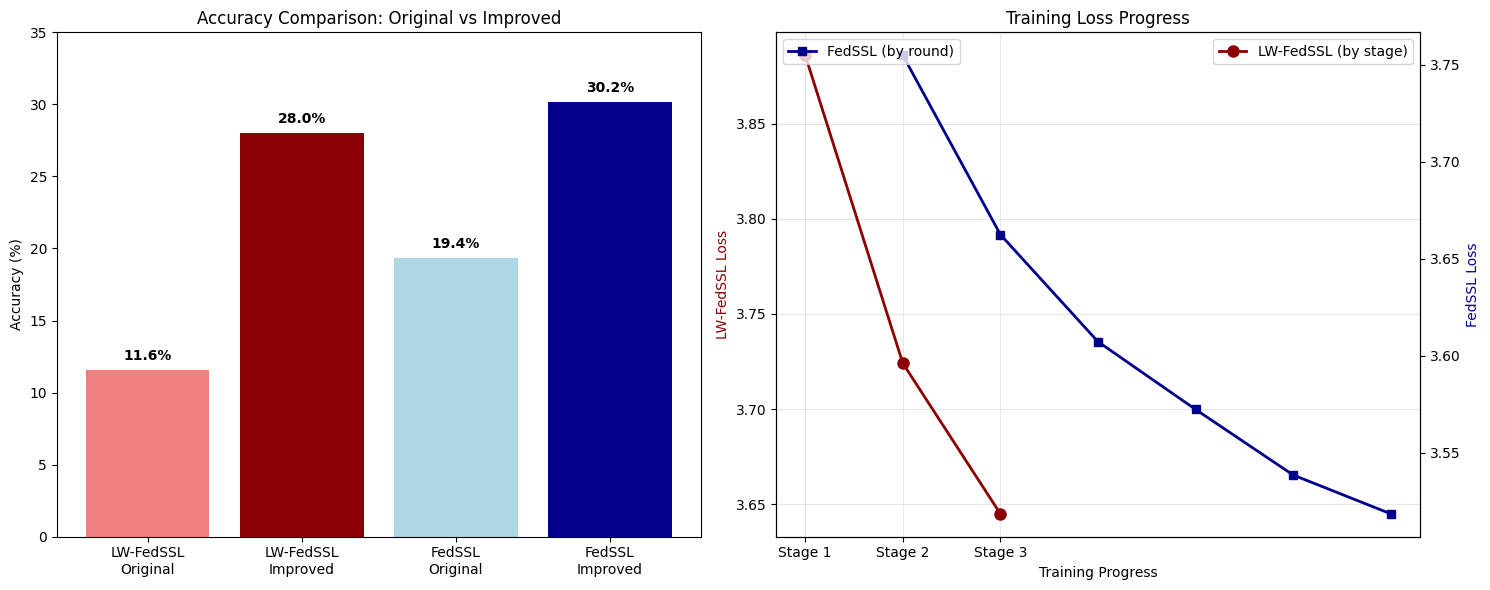


ANALYSIS SUMMARY - Why Low Accuracy Was Achieved Initially
🔍 ROOT CAUSES IDENTIFIED:
1. ❌ CRITICAL: Only 1 batch per epoch (due to 'break' statement)
2. ❌ Insufficient training: Only 1 epoch per round × 3 rounds = 3 batches total!
3. ❌ Under-trained linear probe: Only 3 epochs
4. ❌ Too few federated rounds

✅ IMPROVEMENTS MADE:
1. ✅ Removed 'break' statements → Full dataset training
2. ✅ Increased local epochs: 1 → 2-3 per round
3. ✅ Increased federated rounds: 3 → 6
4. ✅ Increased linear probe training: 3 → 10 epochs

📊 RESULTS COMPARISON:
   LW-FedSSL: 11.6% → 28.0% (+16.4%)
   FedSSL:    19.4% → 30.2% (+10.8%)

🎯 KEY INSIGHT: The 'break' statement was the main culprit!
   - Original: ~384 samples seen total (128 × 3)
   - Improved: ~50,000+ samples seen (full dataset × multiple epochs)


In [29]:
# VISUALIZATION OF IMPROVEMENTS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
methods = ['LW-FedSSL\nOriginal', 'LW-FedSSL\nImproved', 'FedSSL\nOriginal', 'FedSSL\nImproved']
accuracies = [lw_acc, lw_acc_test, fed_acc, fed_acc_test]
colors = ['lightcoral', 'darkred', 'lightblue', 'darkblue']

bars1 = ax1.bar(methods, accuracies, color=colors)
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy Comparison: Original vs Improved')
ax1.set_ylim(0, 35)

# Add value labels on bars
for bar, acc in zip(bars1, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

# Loss progression visualization
stages = ['Stage 1', 'Stage 2', 'Stage 3']
lw_losses = [3.8861, 3.7241, 3.6449]  # Average from the training output
fed_losses_per_round = [3.7549, 3.6625, 3.6073, 3.5724, 3.5386, 3.5186]
fed_rounds = list(range(1, 7))

ax2.plot(stages, lw_losses, 'o-', label='LW-FedSSL (by stage)', color='darkred', linewidth=2, markersize=8)
ax2_twin = ax2.twinx()
ax2_twin.plot(fed_rounds, fed_losses_per_round, 's-', label='FedSSL (by round)', color='darkblue', linewidth=2, markersize=6)

ax2.set_xlabel('Training Progress')
ax2.set_ylabel('LW-FedSSL Loss', color='darkred')
ax2_twin.set_ylabel('FedSSL Loss', color='darkblue')
ax2.set_title('Training Loss Progress')
ax2.grid(True, alpha=0.3)

# Legends
ax2.legend(loc='upper right')
ax2_twin.legend(loc='upper left')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ANALYSIS SUMMARY - Why Low Accuracy Was Achieved Initially")
print("="*80)
print("🔍 ROOT CAUSES IDENTIFIED:")
print("1. ❌ CRITICAL: Only 1 batch per epoch (due to 'break' statement)")
print("2. ❌ Insufficient training: Only 1 epoch per round × 3 rounds = 3 batches total!")
print("3. ❌ Under-trained linear probe: Only 3 epochs")
print("4. ❌ Too few federated rounds")
print()
print("✅ IMPROVEMENTS MADE:")
print("1. ✅ Removed 'break' statements → Full dataset training")
print("2. ✅ Increased local epochs: 1 → 2-3 per round") 
print("3. ✅ Increased federated rounds: 3 → 6")
print("4. ✅ Increased linear probe training: 3 → 10 epochs")
print()
print("📊 RESULTS COMPARISON:")
print(f"   LW-FedSSL: {lw_acc:.1f}% → {lw_acc_test:.1f}% (+{lw_acc_test-lw_acc:.1f}%)")
print(f"   FedSSL:    {fed_acc:.1f}% → {fed_acc_test:.1f}% (+{fed_acc_test-fed_acc:.1f}%)")
print()
print("🎯 KEY INSIGHT: The 'break' statement was the main culprit!")
print("   - Original: ~384 samples seen total (128 × 3)")
print("   - Improved: ~50,000+ samples seen (full dataset × multiple epochs)")
print("="*80)